In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
cp=1
cv=0.4
cd=0.1
h=0.1
demand_rate=17

In [ ]:
#Q1
Q=90
L=7
beta=0.8
K=20,200

## Q1 (a)

In [ ]:
def get_demand(demand_rate):
    demand = np.random.poisson(lam=demand_rate)
    return demand

In [ ]:
def next_State(previous_state):
    new_state = np.zeros(6).tolist() ## start with all zero
    d = get_demand(17)
    for i in range(6): ## L-1
        new_state[i]=np.maximum((previous_state[i]-np.minimum(Q,d)),0) ## new state inventory
    updated_state=new_state[1:]+[Q-d] 
    return updated_state

In [ ]:
def K_path(initial_state,K):
    states=[]
    for i in range(K):
        x = initial_state
        for j in range(1000): ## select the 1000th state
            updated_state = next_State(x) 
            x = updated_state
        states.append(x)
    return states

In [ ]:
initial_state = np.zeros(6).tolist()
path_20 = K_path(initial_state,20) ## full path with K = 20
path_200 = K_path(initial_state,200)  ## full path with K = 200

## Q1 (b)

In [ ]:
def d_profits(K_states,N,T):
  K_num = len(K_states)
  df = pd.DataFrame(columns = ['vmean', 'epsilons', 'CI'])
  for k in range(K_num):
    value_estimates = []
    #x0 = K_states[k]
    for i in range(N):
      x = K_states[k]
      v = 0
      for t in range(T):
        x_initial = next_State(x)[0] ## inital state
        d = Q-x[-1] ## most recent inventory
        reward = min(Q,d) * cp - cv*d - cd*max(x_initial-d,0) - h*max(Q-x_initial-max(d-x_initial,0),0) ## disposal period 1
        v = v+ (beta ** t) * reward
        x = next_State(x)
      value_estimates.extend([v])
    V = np.mean(value_estimates)
    epsilon = 1.96 * np.std(value_estimates)/np.sqrt(N)
    #print(epsilon)
    CI = [V-epsilon,V+epsilon]
    df = df.append({'vmean' : V, 'epsilons' : epsilon, 'CI' : CI},ignore_index=True)
  return df

In [ ]:
profits_20=d_profits(path_20,100,100)
profits_20

I use length = 100 to apply law of large numbers for the results to converge.

Larger episodes are expected but it takes much longer for function to generate results.

In [ ]:
#profits_20 = list((map(discounted_profits,K_20)))

## Q1 c)

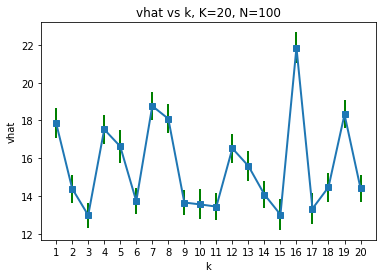

In [ ]:
x = np.linspace(1,20,num=20).astype('int')
plt.errorbar(x, profits_20['vmean'], yerr= profits_20['epsilons'],marker ='s',ecolor='green',linewidth=2)
plt.xticks(x)
plt.xlabel('k')
plt.ylabel('vhat')
plt.title('vhat vs k, K=20, N=100')
plt.show()

In [ ]:
profits_20_N1000 = d_profits(path_20,1000,100) ## find path K=20, N=1000

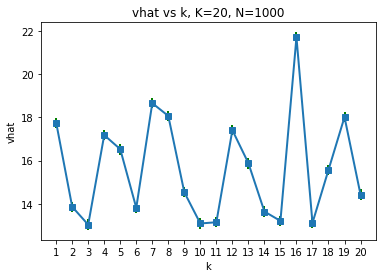

In [ ]:
x = np.linspace(1,20,num=20).astype('int')
plt.errorbar(x, profits_20_N1000['vmean'], yerr= profits_20_N1000['epsilons'],marker ='s',ecolor='green',linewidth=2)
plt.xticks(x)
plt.xlabel('k')
plt.ylabel('vhat')
plt.title('vhat vs k, K=20, N=1000')
plt.show()

Larger N corresponds to smaller comfidence interval

In [ ]:
profits_200_N100 = d_profits(path_200,100,100) ## find full path K=200, N=100

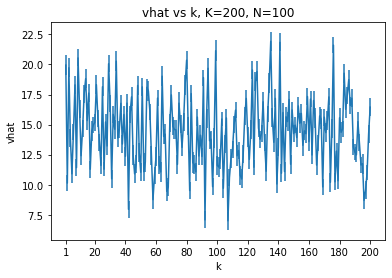

In [ ]:
x = np.linspace(1,200,200).astype('int')
x1 = np.linspace(1,200,11).astype('int')
plt.errorbar(x, profits_200_N100['vmean'], yerr=profits_200_N100['epsilons'])
plt.xticks(x1)
plt.xlabel('k')
plt.ylabel('vhat')
plt.title('vhat vs k, K=200, N=100')
plt.show()

In [ ]:
profits_200_N1000 = d_profits(path_200,1000,100) ## find full path K=200,N=1000

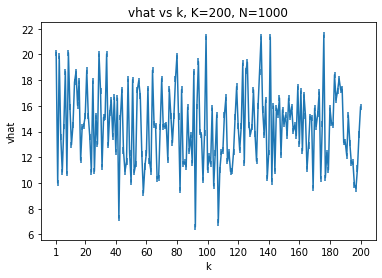

In [ ]:
x = np.linspace(1,200,200).astype('int')
plt.errorbar(x, profits_200_N1000['vmean'], yerr=profits_200_N1000['epsilons'])
plt.xticks(np.linspace(1,200,11).astype('int'))
plt.xlabel('k')
plt.ylabel('vhat')
plt.title('vhat vs k, K=200, N=1000')
plt.show()

###Q2 a)

In [ ]:
class MyNeuralNetwork:
    def __init__(self, input_dimension):
        # define the keras model
        self.model = Sequential()
        self.model.add(Dense(5, input_dim=input_dimension,
                             activation='relu'))
        self.model.add(Dense(5, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        # compile the keras model
        self.model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
class Scaler:
    # save mean and variance of x, y sets
    def __init__(self, x, y):
        self.x_mean = np.mean(x, axis=0)
        self.y_mean = np.mean(y, axis=0)
        self.x_std = np.std(x, axis=0)
        self.y_std = np.std(y, axis=0)


    def get_x(self):
        # return saved mean and variance of x
        return self.x_std, self.x_mean

    def get_y(self):
        # return saved mean and variance of y
        return self.y_std, self.y_mean

In [ ]:
x_train= path_200
x_test= [[10,20,30,40,50,80]] ## dimension match 
y_train= profits_200_N1000['vmean']
y_test= d_profits(x_test,1000,100)['vmean']

In [ ]:
neural_network = MyNeuralNetwork(input_dimension=6)

In [ ]:
normalizer = Scaler(x_train, y_train)
std_x, mean_x = normalizer.get_x()
x_train_norm = (x_train - mean_x) / std_x
x_test_norm = (x_test - mean_x) / std_x
std_y, mean_y = normalizer.get_y()
y_train_norm = (y_train - mean_y) / std_y

In [ ]:
neural_network.model.fit(x_train_norm, y_train_norm, epochs=100, batch_size=8)  # train neural network
y_from_nn_norm = neural_network.model.predict(x_test_norm)  # predict values for x_test states
y_from_nn = y_from_nn_norm * std_y + mean_y  # tranform the results into original scaling
mse = mean_squared_error(y_test, y_from_nn) # compute mean squared error
print('Mean squared error: ', mse)

In [ ]:
d_profits(x_test,1000,100)

,vmean,epsilons,CI
0,9.72865,0.232939,"[9.495710876112097, 9.961588977201282]"


$\hat{v} = 9.73$ 

CI = [9.49,9.96]

In [ ]:
y_from_nn

array([[9.975146]], dtype=float32)

$ \tilde{v} = 9.97 $

## Q2 b)

In [ ]:
# find v_tilda and mse given x_test and y_test
def get_vt(x_test,y_test):
    x_test_norm = (x_test - mean_x) / std_x
    y_from_nn_norm = neural_network.model.predict(x_test_norm)  # predict values for x_test states
    y_from_nn = y_from_nn_norm * std_y + mean_y  # tranform the results into original scaling
    mse = mean_squared_error(y_test, y_from_nn) # compute mean squared error
    return y_from_nn,mse

In [ ]:
path_50K = K_path([10,20,30,40,50,80],50000) ## find full path for K=50000

In [ ]:
# Select the 50 states into test set
testset_states=[]
for i in np.linspace(1000,50000,50).astype('int'):
    testset_states.append(path_50K[i-1]) ## start from zero

In [ ]:
## find vt and vh for all states in test set
vh = d_profits(testset_states,1000,100)
vt,mse = get_vt(testset_states,vh['vmean'])

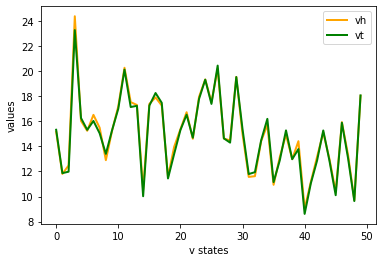

In [ ]:
plt.plot(vh['vmean'], label="vh", lw=2, c = 'orange')
plt.plot(vt, label="vt", lw=2, c = 'g')
plt.xlabel('v states')
plt.ylabel('values')
plt.legend()
plt.show()

Two results are pretty close to each other. Predicted results from neural network is close to true value.

##Q2 c)

In [ ]:
vt_20,mse_20 = get_vt(path_20,profits_20_N1000['vmean'])

In [ ]:
## k=200
vt_200,mse_200 = get_vt(path_200,profits_200_N1000['vmean'])

In [ ]:
print('mse for 20 path: ', mse_20)
print('mse for 200 path: ', mse_200)

mse for 20 path:  0.18495169531215308
mse for 200 path:  0.07328266091409562


I received help from Zachary (TA) for generating states function, discounted profits function, confidence interval calculation and the meaning of vt. He also helped with explaining the logic behind this whole process. Some parts of the code were refered to lecture sildes on Monte Carlo Simulation and sample code in regression.ipynb. 